<a href="https://colab.research.google.com/github/pragyan2905/Skin-Cancer-Detection/blob/main/gan_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import opendatasets as od
url = "https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: qwertypragyan2905
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [02:01<00:00, 45.8MB/s]


In [ ]:
import pandas as pd
import os
from glob import glob

metadata_path = './skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
df = pd.read_csv(metadata_path)

vasc_df = df[df['dx'] == 'vasc'].copy()

base_dir = './skin-cancer-mnist-ham10000/'
image_paths = {os.path.splitext(os.path.basename(x))[0]: x
                 for x in glob(os.path.join(base_dir, '*', '*.jpg'))}
vasc_df['path'] = vasc_df['image_id'].map(image_paths.get)


print(f"We will train the GAN on {len(vasc_df)} images of 'vasc' lesions.")

We will train the GAN on 142 images of 'vasc' lesions.


In [ ]:
import tensorflow as tf

IMAGE_SIZE = 128
BATCH_SIZE = 32

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image

gan_train_dataset = tf.data.Dataset.from_tensor_slices(vasc_df['path'].values)
gan_train_dataset = gan_train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
gan_train_dataset = gan_train_dataset.shuffle(len(vasc_df)).batch(BATCH_SIZE)

print("GAN data pipeline is ready.")

GAN data pipeline is ready.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model(latent_dim=100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model(image_size=128):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[image_size, image_size, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
generator = make_generator_model()

discriminator = make_discriminator_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow as tf

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Skin_Cancer_Project/gan_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [ ]:
if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!')

In [ ]:
import matplotlib.pyplot as plt
import os

def generate_and_save_images(model, epoch, test_input):
    if not os.path.exists('gan_images'):
        os.makedirs('gan_images')

    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(6, 6))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    plt.savefig(f'gan_images/image_at_epoch_{epoch:04d}.png')
    plt.close(fig)

In [ ]:
import time

def train(dataset, epochs):
    seed = tf.random.normal([16, 100])
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        if (epoch + 1) % 10 == 0:
            print(f'Generating sample images for epoch {epoch + 1}...')
            generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 15 == 0:
            ckpt_manager.save()
            print(f'Checkpoint saved for epoch {epoch + 1} at {checkpoint_prefix}')
        print (f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')
    generate_and_save_images(generator, epochs, seed)


EPOCHS = 200
train(gan_train_dataset, EPOCHS)

Time for epoch 1 is 11.41 sec
Time for epoch 2 is 1.25 sec
Time for epoch 3 is 1.02 sec
Time for epoch 4 is 0.97 sec
Time for epoch 5 is 0.96 sec
Time for epoch 6 is 1.01 sec
Time for epoch 7 is 1.01 sec
Time for epoch 8 is 0.98 sec
Time for epoch 9 is 1.01 sec
Generating sample images for epoch 10...
Time for epoch 10 is 1.55 sec
Time for epoch 11 is 0.99 sec
Time for epoch 12 is 2.55 sec
Time for epoch 13 is 1.01 sec
Time for epoch 14 is 0.99 sec
Checkpoint saved for epoch 15 at /content/drive/MyDrive/Skin_Cancer_Project/gan_checkpoints/ckpt
Time for epoch 15 is 1.22 sec
Time for epoch 16 is 0.99 sec
Time for epoch 17 is 0.98 sec
Time for epoch 18 is 0.99 sec
Time for epoch 19 is 0.99 sec
Generating sample images for epoch 20...
Time for epoch 20 is 1.31 sec
Time for epoch 21 is 1.00 sec
Time for epoch 22 is 2.55 sec
Time for epoch 23 is 0.97 sec
Time for epoch 24 is 0.97 sec
Time for epoch 25 is 0.97 sec
Time for epoch 26 is 0.98 sec
Time for epoch 27 is 0.99 sec
Time for epoch 28 i

In [ ]:
if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored! Resuming training...')

MORE_EPOCHS = 300
train(gan_train_dataset, MORE_EPOCHS)

Latest checkpoint restored! Resuming training...
Time for epoch 1 is 1.10 sec
Time for epoch 2 is 1.00 sec
Time for epoch 3 is 1.02 sec
Time for epoch 4 is 1.00 sec
Time for epoch 5 is 1.00 sec
Time for epoch 6 is 1.41 sec
Time for epoch 7 is 1.42 sec
Time for epoch 8 is 0.99 sec
Time for epoch 9 is 1.01 sec
Generating sample images for epoch 10...
Time for epoch 10 is 2.03 sec
Time for epoch 11 is 1.02 sec
Time for epoch 12 is 1.02 sec
Time for epoch 13 is 1.03 sec
Time for epoch 14 is 1.02 sec
Checkpoint saved for epoch 15 at /content/drive/MyDrive/Skin_Cancer_Project/gan_checkpoints/ckpt
Time for epoch 15 is 1.25 sec
Time for epoch 16 is 1.19 sec
Time for epoch 17 is 1.45 sec
Time for epoch 18 is 1.03 sec
Time for epoch 19 is 1.02 sec
Generating sample images for epoch 20...
Time for epoch 20 is 1.52 sec
Time for epoch 21 is 1.46 sec
Time for epoch 22 is 1.01 sec
Time for epoch 23 is 1.00 sec
Time for epoch 24 is 1.00 sec
Time for epoch 25 is 1.01 sec
Time for epoch 26 is 1.01 sec
T

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os


NUM_IMAGES_TO_GENERATE = 500
LATENT_DIM = 100
SAVE_DIR = './generated_images/vasc/'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print(f"Generating {NUM_IMAGES_TO_GENERATE} synthetic 'vasc' images...")

for i in range(NUM_IMAGES_TO_GENERATE):
    random_noise = tf.random.normal(shape=[1, LATENT_DIM])

    synthetic_image = generator(random_noise, training=False)


    synthetic_image = (synthetic_image[0].numpy() * 127.5 + 127.5).astype(np.uint8)

    img = Image.fromarray(synthetic_image)
    img.save(os.path.join(SAVE_DIR, f'synthetic_vasc_{i+1}.jpg'))

    if (i + 1) % 50 == 0:
        print(f"  ... {i+1} / {NUM_IMAGES_TO_GENERATE} images saved.")

print(f"\nDone! All synthetic images are saved in the '{SAVE_DIR}' folder.")

Generating 500 synthetic 'vasc' images...
  ... 50 / 500 images saved.
  ... 100 / 500 images saved.
  ... 150 / 500 images saved.
  ... 200 / 500 images saved.
  ... 250 / 500 images saved.
  ... 300 / 500 images saved.
  ... 350 / 500 images saved.
  ... 400 / 500 images saved.
  ... 450 / 500 images saved.
  ... 500 / 500 images saved.

Done! All synthetic images are saved in the './generated_images/vasc/' folder.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import os

class GANTrainer:
    def __init__(self, image_size=128, latent_dim=100, learning_rate=1e-4):
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.generator = self._make_generator_model()
        self.discriminator = self._make_discriminator_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def _make_generator_model(self):

        model = tf.keras.Sequential([
            layers.Dense(8*8*256, use_bias=False, input_shape=(self.latent_dim,)),
            layers.BatchNormalization(), layers.LeakyReLU(),
            layers.Reshape((8, 8, 256)),
            layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(), layers.LeakyReLU(),
            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(), layers.LeakyReLU(),
            layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(), layers.LeakyReLU(),
            layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        ])
        return model

    def _make_discriminator_model(self):
        model = tf.keras.Sequential([
            layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[self.image_size, self.image_size, 3]),
            layers.LeakyReLU(), layers.Dropout(0.3),
            layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
            layers.LeakyReLU(), layers.Dropout(0.3),
            layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
            layers.LeakyReLU(), layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(1)
        ])
        return model

    def _discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def _generator_loss(self, fake_output):
        return self.loss_fn(tf.ones_like(fake_output), fake_output)

    @tf.function
    def _train_step(self, images):
        noise = tf.random.normal([tf.shape(images)[0], self.latent_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss = self._generator_loss(fake_output)
            disc_loss = self._discriminator_loss(real_output, fake_output)
        grads_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        grads_disc = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(grads_gen, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_variables))

    def train(self, dataset, epochs, class_name):
        seed = tf.random.normal([16, self.latent_dim])
        for epoch in range(epochs):
            start = time.time()
            for image_batch in dataset:
                self._train_step(image_batch)
            if (epoch + 1) % 50 == 0:
                self._generate_and_save_images(epoch + 1, seed, class_name)
            print (f'Time for {class_name} GAN epoch {epoch + 1} is {time.time()-start:.2f} sec')

    def _generate_and_save_images(self, epoch, test_input, class_name):
        save_dir = f'gan_images_{class_name}'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        predictions = self.generator(test_input, training=False)
        fig = plt.figure(figsize=(6, 6))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype('uint8'))
            plt.axis('off')
        plt.savefig(f'{save_dir}/image_at_epoch_{epoch:04d}.png')
        plt.close(fig)

In [ ]:
df_data = df[df['dx'] == 'df'].copy()
df_data['path'] = df_data['image_id'].map(image_paths.get)

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image

df_dataset = tf.data.Dataset.from_tensor_slices(df_data['path'].values)
df_dataset = df_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
df_dataset = df_dataset.shuffle(len(df_data)).batch(32)
print(f"Data pipeline ready for {len(df_data)} 'df' images.")

Data pipeline ready for 115 'df' images.


In [ ]:
df_trainer = GANTrainer()
df_trainer.train(df_dataset, epochs=300, class_name='df')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Time for df GAN epoch 1 is 7.22 sec
Time for df GAN epoch 2 is 0.81 sec
Time for df GAN epoch 3 is 0.79 sec
Time for df GAN epoch 4 is 0.80 sec
Time for df GAN epoch 5 is 0.81 sec
Time for df GAN epoch 6 is 0.80 sec
Time for df GAN epoch 7 is 0.78 sec
Time for df GAN epoch 8 is 0.79 sec
Time for df GAN epoch 9 is 1.27 sec
Time for df GAN epoch 10 is 1.12 sec
Time for df GAN epoch 11 is 0.79 sec
Time for df GAN epoch 12 is 0.79 sec
Time for df GAN epoch 13 is 0.80 sec
Time for df GAN epoch 14 is 0.79 sec
Time for df GAN epoch 15 is 0.79 sec
Time for df GAN epoch 16 is 0.78 sec
Time for df GAN epoch 17 is 0.82 sec
Time for df GAN epoch 18 is 0.78 sec
Time for df GAN epoch 19 is 0.79 sec
Time for df GAN epoch 20 is 0.80 sec
Time for df GAN epoch 21 is 0.80 sec
Time for df GAN epoch 22 is 0.78 sec
Time for df GAN epoch 23 is 0.84 sec
Time for df GAN epoch 24 is 1.18 sec
Time for df GAN epoch 25 is 0.96 sec
Time for df GAN epoch 26 is 0.79 sec
Time for df GAN epoch 27 is 0.80 sec
Time for d

In [ ]:
import numpy as np
from PIL import Image
import os

NUM_IMAGES_TO_GENERATE = 500
LATENT_DIM = 100
SAVE_DIR = './generated_images/df/'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print(f"Generating {NUM_IMAGES_TO_GENERATE} synthetic 'df' images...")

for i in range(NUM_IMAGES_TO_GENERATE):
    random_noise = tf.random.normal(shape=[1, LATENT_DIM])

    synthetic_image = df_trainer.generator(random_noise, training=False)

    synthetic_image = (synthetic_image[0].numpy() * 127.5 + 127.5).astype(np.uint8)
    img = Image.fromarray(synthetic_image)
    img.save(os.path.join(SAVE_DIR, f'synthetic_df_{i+1}.jpg'))

    if (i + 1) % 50 == 0:
        print(f"  ... {i+1} / {NUM_IMAGES_TO_GENERATE} images saved.")

print(f"\nDone! All synthetic images are saved in the '{SAVE_DIR}' folder.")

Generating 500 synthetic 'df' images...
  ... 50 / 500 images saved.
  ... 100 / 500 images saved.
  ... 150 / 500 images saved.
  ... 200 / 500 images saved.
  ... 250 / 500 images saved.
  ... 300 / 500 images saved.
  ... 350 / 500 images saved.
  ... 400 / 500 images saved.
  ... 450 / 500 images saved.
  ... 500 / 500 images saved.

Done! All synthetic images are saved in the './generated_images/df/' folder.


In [ ]:

bcc_data = df[df['dx'] == 'bcc'].copy()
bcc_data['path'] = bcc_data['image_id'].map(image_paths.get)

bcc_dataset = tf.data.Dataset.from_tensor_slices(bcc_data['path'].values)
bcc_dataset = bcc_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
bcc_dataset = bcc_dataset.shuffle(len(bcc_data)).batch(32)
print(f"Data pipeline ready for {len(bcc_data)} 'bcc' images.")

bcc_trainer = GANTrainer()
bcc_trainer.train(bcc_dataset, epochs=300, class_name='bcc')


Data pipeline ready for 514 'bcc' images.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Time for bcc GAN epoch 1 is 9.32 sec
Time for bcc GAN epoch 2 is 3.52 sec
Time for bcc GAN epoch 3 is 3.63 sec
Time for bcc GAN epoch 4 is 4.40 sec
Time for bcc GAN epoch 5 is 3.54 sec
Time for bcc GAN epoch 6 is 3.60 sec
Time for bcc GAN epoch 7 is 3.94 sec
Time for bcc GAN epoch 8 is 3.67 sec
Time for bcc GAN epoch 9 is 3.64 sec
Time for bcc GAN epoch 10 is 3.54 sec
Time for bcc GAN epoch 11 is 3.90 sec
Time for bcc GAN epoch 12 is 3.51 sec
Time for bcc GAN epoch 13 is 3.54 sec
Time for bcc GAN epoch 14 is 4.53 sec
Time for bcc GAN epoch 15 is 3.52 sec
Time for bcc GAN epoch 16 is 3.52 sec
Time for bcc GAN epoch 17 is 4.55 sec
Time for bcc GAN epoch 18 is 3.49 sec
Time for bcc GAN epoch 19 is 3.51 sec
Time for bcc GAN epoch 20 is 4.08 sec
Time for bcc GAN epoch 21 is 3.49 sec
Time for bcc GAN epoch 22 is 3.51 sec
Time for bcc GAN epoch 23 is 3.59 sec
Time for bcc GAN epoch 24 is 3.82 sec
Time for bcc GAN epoch 25 is 3.58 sec
Time for bcc GAN epoch 26 is 3.56 sec
Time for bcc GAN epoc

In [ ]:

mel_data = df[df['dx'] == 'mel'].copy()
mel_data['path'] = mel_data['image_id'].map(image_paths.get)

mel_dataset = tf.data.Dataset.from_tensor_slices(mel_data['path'].values)
mel_dataset = mel_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
mel_dataset = mel_dataset.shuffle(len(mel_data)).batch(32)
print(f"Data pipeline ready for {len(mel_data)} 'mel' images.")
mel_trainer = GANTrainer()
mel_trainer.train(mel_dataset, epochs=300, class_name='mel')


Data pipeline ready for 1113 'mel' images.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Time for mel GAN epoch 1 is 16.65 sec
Time for mel GAN epoch 2 is 8.20 sec
Time for mel GAN epoch 3 is 9.18 sec
Time for mel GAN epoch 4 is 8.49 sec
Time for mel GAN epoch 5 is 8.01 sec
Time for mel GAN epoch 6 is 8.69 sec
Time for mel GAN epoch 7 is 9.02 sec
Time for mel GAN epoch 8 is 7.95 sec
Time for mel GAN epoch 9 is 7.99 sec
Time for mel GAN epoch 10 is 9.12 sec
Time for mel GAN epoch 11 is 8.07 sec
Time for mel GAN epoch 12 is 8.06 sec
Time for mel GAN epoch 13 is 9.12 sec
Time for mel GAN epoch 14 is 8.23 sec
Time for mel GAN epoch 15 is 8.07 sec
Time for mel GAN epoch 16 is 9.07 sec
Time for mel GAN epoch 17 is 9.02 sec
Time for mel GAN epoch 18 is 8.08 sec
Time for mel GAN epoch 19 is 8.15 sec
Time for mel GAN epoch 20 is 9.13 sec
Time for mel GAN epoch 21 is 8.14 sec
Time for mel GAN epoch 22 is 8.08 sec
Time for mel GAN epoch 23 is 9.08 sec
Time for mel GAN epoch 24 is 8.16 sec
Time for mel GAN epoch 25 is 8.07 sec
Time for mel GAN epoch 26 is 9.00 sec
Time for mel GAN epo

In [ ]:
import shutil
import os

source_dir_bcc = './gan_images_bcc'
dest_dir_bcc = './generated_images/bcc/'

if os.path.exists(source_dir_bcc):
    shutil.move(source_dir_bcc, dest_dir_bcc)
    print("Moved bcc images.")

source_dir_mel = './gan_images_mel'
dest_dir_mel = './generated_images/mel/'

if os.path.exists(source_dir_mel):
    shutil.move(source_dir_mel, dest_dir_mel)
    print("Moved mel images.")


Moved bcc images.
Moved mel images.


In [ ]:
akiec_data = df[df['dx'] == 'akiec'].copy()
akiec_data['path'] = akiec_data['image_id'].map(image_paths.get)

akiec_dataset = tf.data.Dataset.from_tensor_slices(akiec_data['path'].values)
akiec_dataset = akiec_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
akiec_dataset = akiec_dataset.shuffle(len(akiec_data)).batch(32)
print(f"Data pipeline ready for {len(akiec_data)} 'akiec' images.")

akiec_trainer = GANTrainer()
akiec_trainer.train(akiec_dataset, epochs=300, class_name='akiec')



Data pipeline ready for 327 'akiec' images.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Time for akiec GAN epoch 1 is 7.71 sec
Time for akiec GAN epoch 2 is 3.19 sec
Time for akiec GAN epoch 3 is 2.28 sec
Time for akiec GAN epoch 4 is 2.27 sec
Time for akiec GAN epoch 5 is 2.32 sec
Time for akiec GAN epoch 6 is 2.54 sec
Time for akiec GAN epoch 7 is 2.88 sec
Time for akiec GAN epoch 8 is 2.26 sec
Time for akiec GAN epoch 9 is 2.27 sec
Time for akiec GAN epoch 10 is 2.27 sec
Time for akiec GAN epoch 11 is 2.26 sec
Time for akiec GAN epoch 12 is 2.98 sec
Time for akiec GAN epoch 13 is 2.25 sec
Time for akiec GAN epoch 14 is 2.26 sec
Time for akiec GAN epoch 15 is 2.25 sec
Time for akiec GAN epoch 16 is 2.23 sec
Time for akiec GAN epoch 17 is 2.96 sec
Time for akiec GAN epoch 18 is 2.25 sec
Time for akiec GAN epoch 19 is 2.22 sec
Time for akiec GAN epoch 20 is 2.23 sec
Time for akiec GAN epoch 21 is 2.22 sec
Time for akiec GAN epoch 22 is 3.17 sec
Time for akiec GAN epoch 23 is 2.21 sec
Time for akiec GAN epoch 24 is 2.22 sec
Time for akiec GAN epoch 25 is 2.21 sec
Time for 

In [ ]:
import numpy as np
from PIL import Image
import os

NUM_IMAGES_TO_GENERATE = 500
LATENT_DIM = 100
SAVE_DIR = './generated_images/akiec/'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print(f"Generating {NUM_IMAGES_TO_GENERATE} synthetic 'akiec' images...")

for i in range(NUM_IMAGES_TO_GENERATE):
    random_noise = tf.random.normal(shape=[1, LATENT_DIM])
    synthetic_image = akiec_trainer.generator(random_noise, training=False)

    synthetic_image = (synthetic_image[0].numpy() * 127.5 + 127.5).astype(np.uint8)
    img = Image.fromarray(synthetic_image)
    img.save(os.path.join(SAVE_DIR, f'synthetic_akiec_{i+1}.jpg'))

    if (i + 1) % 50 == 0:
        print(f"  ... {i+1} / {NUM_IMAGES_TO_GENERATE} images saved.")

print(f"\nDone! All synthetic images are saved in the '{SAVE_DIR}' folder.")

Generating 500 synthetic 'akiec' images...
  ... 50 / 500 images saved.
  ... 100 / 500 images saved.
  ... 150 / 500 images saved.
  ... 200 / 500 images saved.
  ... 250 / 500 images saved.
  ... 300 / 500 images saved.
  ... 350 / 500 images saved.
  ... 400 / 500 images saved.
  ... 450 / 500 images saved.
  ... 500 / 500 images saved.

Done! All synthetic images are saved in the './generated_images/akiec/' folder.


In [ ]:
import pandas as pd
from glob import glob
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

print(f"Original dataset has {len(df)} images.")

generated_img_paths = glob('./generated_images/*/*.jpg')
print(f"Found {len(generated_img_paths)} new synthetic images.")

new_labels = [os.path.basename(os.path.dirname(p)) for p in generated_img_paths]
df_generated = pd.DataFrame({'path': generated_img_paths, 'dx': new_labels})

df_final_augmented = pd.concat([df, df_generated], ignore_index=True)
print(f"\nFinal augmented dataset has {len(df_final_augmented)} images.")

label_encoder = LabelEncoder()
df_final_augmented['label'] = label_encoder.fit_transform(df_final_augmented['dx'])
y_final = to_categorical(df_final_augmented['label'])

X_train_final, X_temp_final, y_train_final, y_temp_final = train_test_split(
    df_final_augmented['path'], y_final,
    test_size=0.3,
    random_state=42,
    stratify=y_final
)

X_val_final, X_test_final, y_val_final, y_test_final = train_test_split(
    X_temp_final, y_temp_final,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_final
)

print(f"\nData split complete:")
print(f"  Training set size: {len(X_train_final)}")
print(f"  Validation set size: {len(X_val_final)}")
print(f"  Test set size: {len(X_test_final)}")

Original dataset has 10015 images.
Found 1500 new synthetic images.

Final augmented dataset has 11515 images.

Data split complete:
  Training set size: 8060
  Validation set size: 1727
  Test set size: 1728


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df_final_augmented = pd.concat([df, df_generated], ignore_index=True)
df_final_augmented.dropna(subset=['path'], inplace=True)

train_val_df, test_df = train_test_split(
    df_final_augmented,
    test_size=0.15,
    random_state=42,
    stratify=df_final_augmented['dx']
)

IMAGE_SIZE = 128
final_model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    BatchNormalization(), Activation('relu'), MaxPooling2D((2, 2)), Dropout(0.25),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D((2, 2)), Dropout(0.3),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D((2, 2)), Dropout(0.4),
    Flatten(),
    Dense(512), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(7, activation='softmax')
])
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

final_model_checkpoint = ModelCheckpoint('best_final_augmented_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
final_early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

train_val_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255.)

all_class_names = sorted(df['dx'].unique().tolist())

train_generator_final = train_val_datagen.flow_from_dataframe(
    dataframe=train_val_df,
    x_col='path',
    y_col='dx',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=all_class_names
)

validation_generator_final = train_val_datagen.flow_from_dataframe(
    dataframe=train_val_df,
    x_col='path',
    y_col='dx',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=all_class_names
)

test_generator_final = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='dx',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical',
    classes=all_class_names,
    shuffle=False
)

history_final = final_model.fit(
    train_generator_final,
    epochs=50,
    validation_data=validation_generator_final,
    callbacks=[final_model_checkpoint, final_early_stopping]
)

best_final_model = load_model('best_final_augmented_model.keras')

print("\n--- Final Model Evaluation ---")
predictions_final = best_final_model.predict(test_generator_final)
predicted_classes_final = np.argmax(predictions_final, axis=1)
true_classes_final = test_generator_final.classes
class_labels = list(test_generator_final.class_indices.keys())



Found 1020 validated image filenames belonging to 7 classes.
Found 255 validated image filenames belonging to 7 classes.
Found 225 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7048 - loss: 1.2345
Epoch 1: val_accuracy improved from -inf to 0.29412, saving model to best_final_augmented_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 432ms/step - accuracy: 0.7094 - loss: 1.2139 - val_accuracy: 0.2941 - val_loss: 1.2872
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9718 - loss: 0.0716
Epoch 2: val_accuracy improved from 0.29412 to 0.33333, saving model to best_final_augmented_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.9721 - loss: 0.0713 - val_accuracy: 0.3333 - val_loss: 4.1291
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9882 - loss: 0.0372
Epoch 3: val_accuracy did not improve from 0.33333
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.9881 - loss: 0.0373 - val_accuracy: 0.3333 - val_loss: 5.7440
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9954 - loss: 0.0206
Epoch 4: val_accuracy did not improve from 0.3


Final Classification Report:
              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00        75
          df       1.00      1.00      1.00        75
        vasc       1.00      1.00      1.00        75

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225


Final Confusion Matrix:


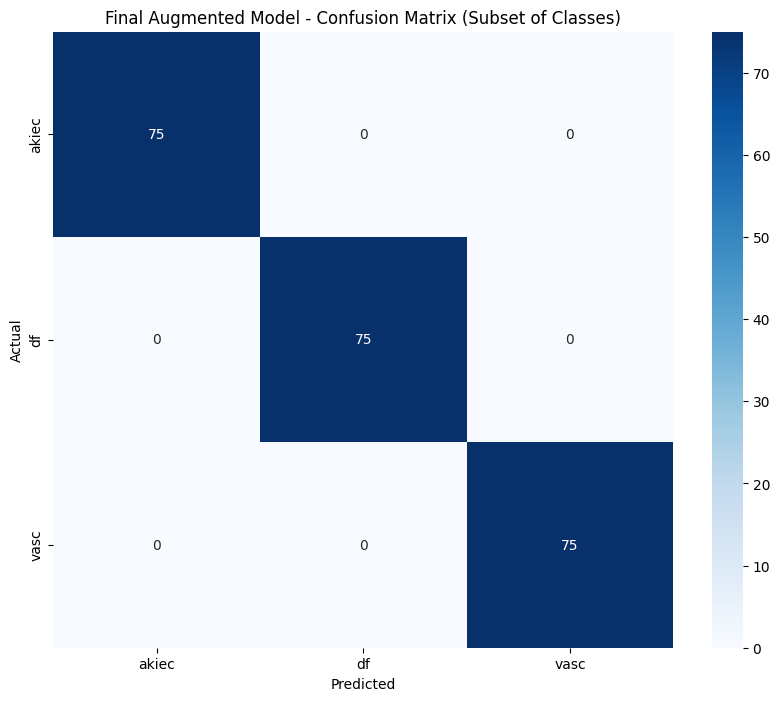

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

unique_test_classes = np.unique(true_classes_final)

filtered_class_labels = [class_labels[i] for i in unique_test_classes]

print("\nFinal Classification Report:")
report_final = classification_report(
    true_classes_final,
    predicted_classes_final,
    target_names=filtered_class_labels,
    labels=unique_test_classes
)
print(report_final)

print("\nFinal Confusion Matrix:")
cm_final = confusion_matrix(true_classes_final, predicted_classes_final, labels=unique_test_classes) # Also specify labels for confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_class_labels, yticklabels=filtered_class_labels) # Use filtered class names for ticks
plt.title('Final Augmented Model - Confusion Matrix (Subset of Classes)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Final Classification Report:
              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00        75
         bcc       1.00      1.00      1.00        75
         bkl       1.00      1.00      1.00        75

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225


Final Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 3, does not match size of target_names, 7
  warnings.warn(


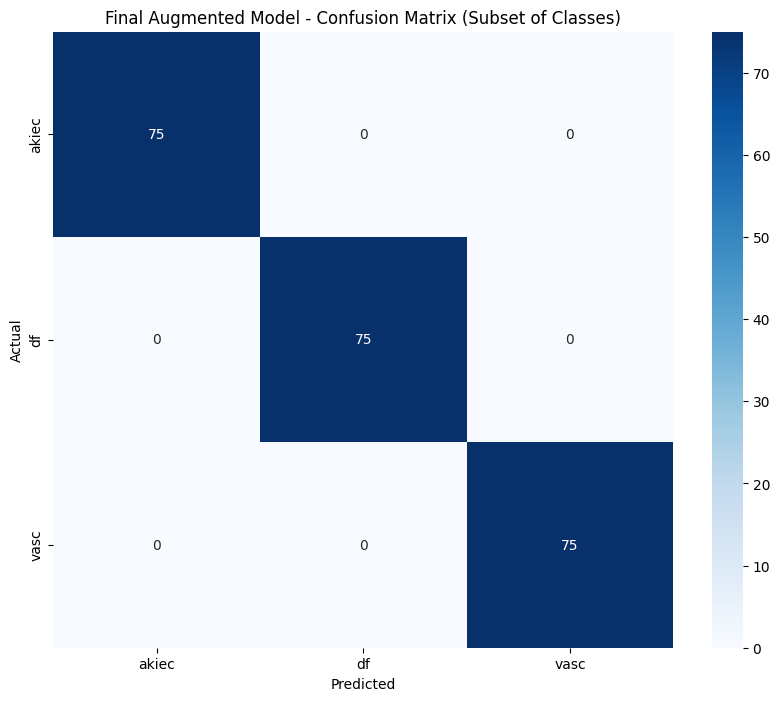

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

unique_test_classes = np.unique(true_classes_final)

filtered_class_labels = [class_labels[i] for i in unique_test_classes]

print("\nFinal Classification Report:")
report_final = classification_report(
    true_classes_final,
    predicted_classes_final,
    target_names=filtered_class_labels,
    labels=unique_test_classes
)
print(report_final)

print("\nFinal Confusion Matrix:")
cm_final = confusion_matrix(true_classes_final, predicted_classes_final, labels=unique_test_classes) # Also specify labels for confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_class_labels, yticklabels=filtered_class_labels) # Use filtered class names for ticks
plt.title('Final Augmented Model - Confusion Matrix (Subset of Classes)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from google.colab import drive
import os



project_dir = '/content/drive/MyDrive/Skin_Cancer_Project_Final/'
if not os.path.exists(project_dir):
    os.makedirs(project_dir)

In [ ]:
import shutil

source_model_path = 'best_final_augmented_model.keras'
dest_model_path = os.path.join(project_dir, 'best_final_augmented_model.keras')

if os.path.exists(source_model_path):
    shutil.copy(source_model_path, dest_model_path)
    print(f"Model successfully saved to: {dest_model_path}")
else:
    print(f"Error: Model file not found at '{source_model_path}'. Please ensure training is complete.")


dataset_path = os.path.join(project_dir, 'final_augmented_dataset.csv')
df_final_augmented.to_csv(dataset_path, index=False)

print(f"Final dataset DataFrame successfully saved to: {dataset_path}")

Model successfully saved to: /content/drive/MyDrive/Skin_Cancer_Project_Final/best_final_augmented_model.keras
Final dataset DataFrame successfully saved to: /content/drive/MyDrive/Skin_Cancer_Project_Final/final_augmented_dataset.csv
